In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt


hitters_df = pd.read_csv('Hitters.csv')
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [2]:
print("Number of null values:", hitters_df["Salary"].isnull().sum())

Number of null values: 59


In [5]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

# Drop any rows the contain missing values, along with the player names
hitters_df_clean = hitters_df.dropna()

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", hitters_df_clean.shape)

# One last check: should return 0
print("Number of null values:", hitters_df_clean["Salary"].isnull().sum())

Dimensions of original data: (322, 20)
Dimensions of modified data: (263, 20)
Number of null values: 0


In [6]:
dummies = pd.get_dummies(hitters_df_clean[['League', 'Division', 'NewLeague']])

y = hitters_df_clean.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = hitters_df_clean.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

In [21]:
X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


In [22]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS, "FeatureSet": feature_set}


In [23]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [33]:
# Could take quite awhile to complete...

models_best = pd.DataFrame(columns=["RSS", "model","FeatureSet"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 19 models on 1 predictors in 0.07489895820617676 seconds.
Processed 171 models on 2 predictors in 0.2941300868988037 seconds.
Processed 969 models on 3 predictors in 1.66532301902771 seconds.
Processed 3876 models on 4 predictors in 7.631752967834473 seconds.
Processed 11628 models on 5 predictors in 28.790868997573853 seconds.
Processed 27132 models on 6 predictors in 97.92149686813354 seconds.
Processed 50388 models on 7 predictors in 179.69607496261597 seconds.
Total elapsed time: 317.9245750904083 seconds.


In [34]:
models_best

,RSS,model,FeatureSet
1,4.321393e+07,<statsmodels.regression.linear_model.Regressio...,"(Hits,)"
2,3.073305e+07,<statsmodels.regression.linear_model.Regressio...,"(Hits, CRBI)"
3,2.941071e+07,<statsmodels.regression.linear_model.Regressio...,"(Hits, CRBI, Division_W)"
4,2.797678e+07,<statsmodels.regression.linear_model.Regressio...,"(Hits, CRBI, PutOuts, Division_W)"
5,2.718780e+07,<statsmodels.regression.linear_model.Regressio...,"(AtBat, Hits, Walks, CRBI, PutOuts)"
6,2.639772e+07,<statsmodels.regression.linear_model.Regressio...,"(AtBat, Hits, Walks, CRBI, PutOuts, Division_W)"
7,2.606413e+07,<statsmodels.regression.linear_model.Regressio...,"(Hits, Walks, CAtBat, CHits, CHmRun, PutOuts, ..."


In [35]:
print(models_best.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Wed, 27 Oct 2021   Prob (F-statistic):                    5.80e-82
Time:                        09:21:38   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [42]:
# Show the best 19-variable model (there's actually only one)
print(getBest(19)["model"].summary())

Processed 1 models on 19 predictors in 0.009380102157592773 seconds.
                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.810
Model:                            OLS   Adj. R-squared (uncentered):              0.795
Method:                 Least Squares   F-statistic:                              54.64
Date:                Wed, 27 Oct 2021   Prob (F-statistic):                    1.31e-76
Time:                        09:24:26   Log-Likelihood:                         -1877.9
No. Observations:                 263   AIC:                                      3794.
Df Residuals:                     244   BIC:                                      3862.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P

In [43]:
models_best.loc[2, "model"].rsquared

0.7614950002332872

In [52]:
models_best.loc[2]["model"].model.exog_names

['Hits', 'CRBI']

In [40]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
6    0.795140
7    0.797728
dtype: float64

Text(0, 0.5, 'BIC')

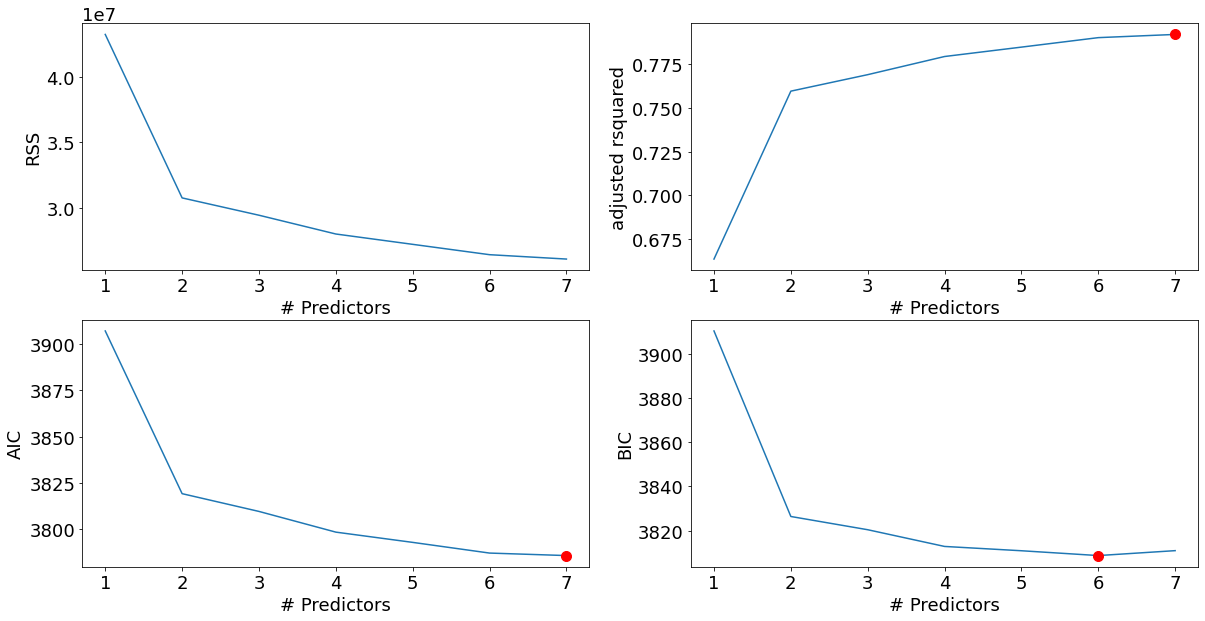

In [44]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html

In [56]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    print(predictors)
    print(remaining_predictors)
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


In [57]:
models_fwd = pd.DataFrame(columns=["RSS", "model","FeatureSet"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

[]
['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W', 'NewLeague_N']
Processed  19 models on 1 predictors in 0.05121898651123047 seconds.
['Hits']
['AtBat', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W', 'NewLeague_N']
Processed  18 models on 2 predictors in 0.05356001853942871 seconds.
['Hits', 'CRBI']
['AtBat', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W', 'NewLeague_N']
Processed  17 models on 3 predictors in 0.03230476379394531 seconds.
['Hits', 'CRBI', 'Division_W']
['AtBat', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'NewLeague_N']
Processed  16 models on 4 predi

In [49]:
models_fwd

,RSS,model,FeatureSet
1,4.321393e+07,<statsmodels.regression.linear_model.Regressio...,[Hits]
2,3.073305e+07,<statsmodels.regression.linear_model.Regressio...,"[Hits, CRBI]"
3,2.941071e+07,<statsmodels.regression.linear_model.Regressio...,"[Hits, CRBI, Division_W]"
4,2.797678e+07,<statsmodels.regression.linear_model.Regressio...,"[Hits, CRBI, Division_W, PutOuts]"
5,2.738163e+07,<statsmodels.regression.linear_model.Regressio...,"[Hits, CRBI, Division_W, PutOuts, AtBat]"
6,2.639772e+07,<statsmodels.regression.linear_model.Regressio...,"[Hits, CRBI, Division_W, PutOuts, AtBat, Walks]"
7,2.621228e+07,<statsmodels.regression.linear_model.Regressio...,"[Hits, CRBI, Division_W, PutOuts, AtBat, Walks..."
8,2.602659e+07,<statsmodels.regression.linear_model.Regressio...,"[Hits, CRBI, Division_W, PutOuts, AtBat, Walks..."
9,2.526445e+07,<statsmodels.regression.linear_model.Regressio...,"[Hits, CRBI, Division_W, PutOuts, AtBat, Walks..."
10,2.493515e+07,<statsmodels.regression.linear_model.Regressio...,"[Hits, CRBI, Division_W, PutOuts, AtBat, Walks..."


Text(0, 0.5, 'BIC')

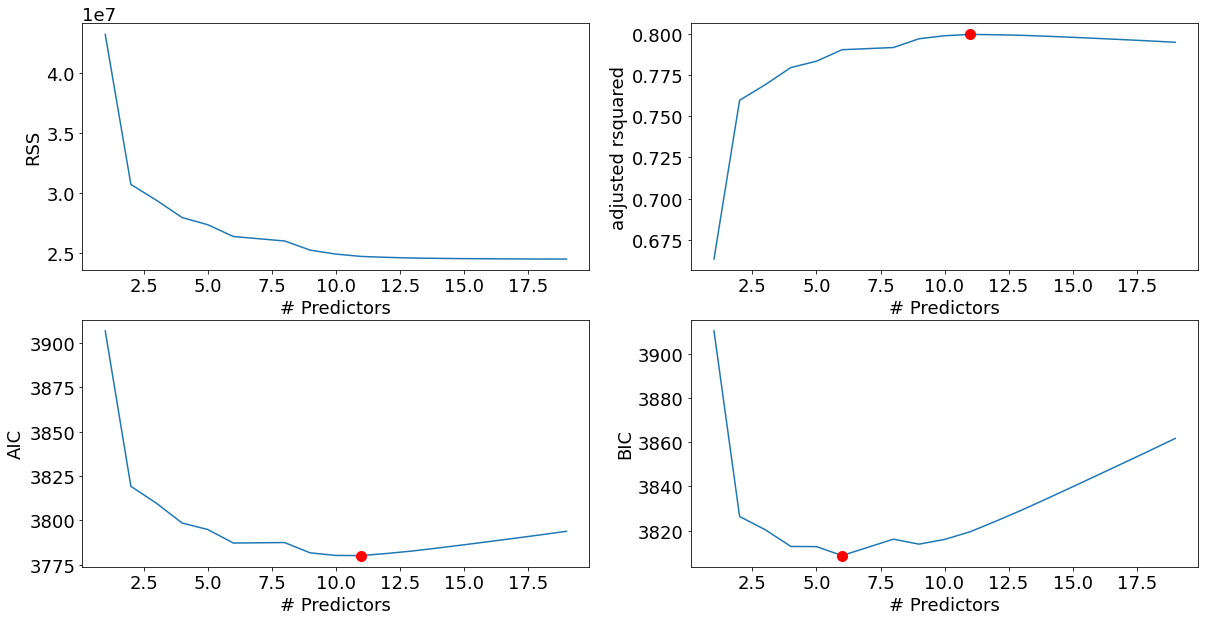

In [60]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_fwd["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_fwd.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_fwd.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_fwd.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [58]:
def backward(predictors):
    
    tic = time.time()
    
    print(predictors)
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [59]:
models_bwd = pd.DataFrame(columns=["RSS", "model","FeatureSet"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'League_N', 'Division_W', 'NewLeague_N'],
      dtype='object')
Processed  19 models on 18 predictors in 0.08241891860961914 seconds.
['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W', 'NewLeague_N']
Processed  18 models on 17 predictors in 0.057289838790893555 seconds.
['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W']
Processed  17 models on 16 predictors in 0.03844404220581055 seconds.
['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W']
Processed  16 models on 15 predictors in 0.0380861759185791

In [53]:
models_bwd

,RSS,model,FeatureSet
1,43213925.909868,<statsmodels.regression.linear_model.Regressio...,"(Hits,)"
2,31300217.014571,<statsmodels.regression.linear_model.Regressio...,"(Hits, CRuns)"
3,29639532.975872,<statsmodels.regression.linear_model.Regressio...,"(Hits, CRuns, PutOuts)"
4,28459155.211339,<statsmodels.regression.linear_model.Regressio...,"(AtBat, Hits, CRuns, PutOuts)"
5,27516763.044165,<statsmodels.regression.linear_model.Regressio...,"(AtBat, Hits, Walks, CRuns, PutOuts)"
6,26821473.246431,<statsmodels.regression.linear_model.Regressio...,"(AtBat, Hits, Walks, CRuns, PutOuts, Division_W)"
7,26195648.698119,<statsmodels.regression.linear_model.Regressio...,"(AtBat, Hits, Walks, CRuns, CWalks, PutOuts, D..."
8,25480303.798845,<statsmodels.regression.linear_model.Regressio...,"(AtBat, Hits, Walks, CRuns, CRBI, CWalks, PutO..."
9,25264447.58596,<statsmodels.regression.linear_model.Regressio...,"(AtBat, Hits, Walks, CRuns, CRBI, CWalks, PutO..."
10,24935150.524503,<statsmodels.regression.linear_model.Regressio...,"(AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWal..."


Text(0, 0.5, 'BIC')

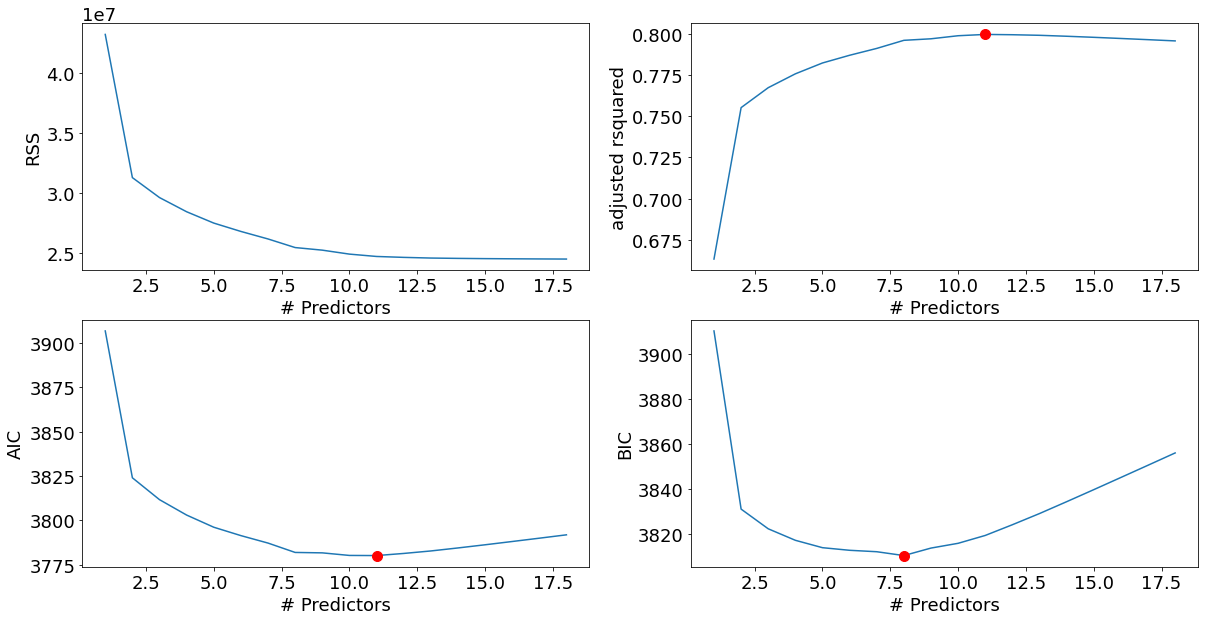

In [61]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_bwd["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_bwd.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_bwd.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_bwd.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [ ]:
http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html